## 1. Searching for gold inside HTML files
<p>It used to take days for financial news to spread via radio, newspapers, and word of mouth. Now, in the age of the internet, it takes seconds. Did you know news articles are <em>automatically</em> being generated from figures and earnings call streams? Hedge funds and independent traders are using data science to process this wealth of information in the quest for profit.</p>
<p>In this notebook, we will generate investing insight by applying <a href="https://en.wikipedia.org/wiki/Sentiment_analysis">sentiment analysis</a> on financial news headlines from <a href="https://finviz.com">FINVIZ.com</a>. Using this <a href="https://en.wikipedia.org/wiki/Natural_language_processing">natural language processing</a> technique, we can understand the emotion behind the headlines and predict whether the market <em>feels</em> good or bad about a stock. It would then be possible to make educated guesses on how certain stocks will perform and trade accordingly. (And hopefully, make money!)</p>
<p><img src="https://assets.datacamp.com/production/project_611/img/fb_headlines.png" alt="Facebook headlines from FINVIZ.com"></p>
<p>Why headlines? And why from FINVIZ?</p>
<ol>
<li>Headlines, which have similar length, are easier to parse and group than full articles, which vary in length.</li>
<li>FINVIZ has a list of trusted websites, and headlines from these sites tend to be more consistent in their jargon than those from independent bloggers. Consistent textual patterns will improve the sentiment analysis.</li>
</ol>
<p>As <a href="https://en.wikipedia.org/wiki/Web_scraping">web scraping</a> requires data science ethics (sending a lot of traffic to a FINVIZ's servers isn't very nice), the HTML files for Facebook and Tesla at various points in time have been downloaded. Let's import these files into memory.</p>
<p><strong>Disclaimer: Investing in the stock market involves risk and can lead to monetary loss. The content in this notebook is not to be taken as financial advice.</strong> </p>

In [2]:
# Import libraries
from bs4 import BeautifulSoup
import os

html_tables = {}

# For every table in the datasets folder...
for table_name in os.listdir('datasets'):
    #this is the path to the file. Don't touch!
    table_path = f'datasets/{table_name}'
    # Open as a python file in read-only mode
    with open(table_path,'r') as table_file:
        # Read the contents of the file into 'html'
        html = BeautifulSoup(table_file, "lxml")
        #print(html.title)
        #print(html.prettify())
        #print(html.find(id='news-table'))
        # Find 'news-table' in the Soup and load it into 'html_table'
        html_table = html.find(id='news-table')
        # Add the table to our dictionary
        html_tables[table_name] = html_table
        

## 2. What is inside those files anyway?
<p>We've grabbed the table that contains the headlines from each stock's HTML file, but before we start parsing those tables further, we need to understand how the data in that table is structured. We have a few options for this:</p>
<ul>
<li>Open the HTML file with a text editor (preferably one with syntax highlighting, like <a href="http://www.sublimetext.com/">Sublime Text</a>) and explore it there</li>
<li>Use your browser's <a href="https://addons.mozilla.org/en-US/firefox/addon/web-developer/">webdev toolkit</a> to explore the HTML</li>
<li>Explore the headlines table here in this notebook!</li>
</ul>
<p>Let's do the third option.</p>

In [6]:
# Read one single day of headlines 
tsla = html_tables['tsla_22sep.html']
print(tsla.find('tr').prettify())
"""
<tr> = table row
<td> = table data (in contrast to <th> table header)
<a> = href
""";

<tr>
 <td align="right" style="white-space:nowrap" width="130">
  Sep-21-18 09:56PM
 </td>
 <td align="left">
  <a class="tab-link-news" href="https://finance.yahoo.com/video/billionaire-investor-questions-elon-musk-015608758.html" target="_blank">
   Billionaire investor questions Elon Musk getting 'a pass' after bombshell tweets
  </a>
  <span style="color:#aa6dc0;font-size:9px">
   Fox Business Videos
  </span>
 </td>
</tr>



In [9]:
tr = tsla.find('tr')
print("Title is:", tr.a.text) # or tr.find('a').text)
print("Date is:", tr.find('td').text)
print("Together:\n", tr.get_text())

Title is: Billionaire investor questions Elon Musk getting 'a pass' after bombshell tweets
Date is: Sep-21-18 09:56PM  
Together:
 Sep-21-18 09:56PM  Billionaire investor questions Elon Musk getting 'a pass' after bombshell tweets Fox Business Videos


In [10]:
# Get all the table rows tagged in HTML with <tr> into 'tesla_tr'
tsla_tr = tsla.find_all('tr')

# For each row...
for i, table_row in enumerate(tsla_tr):
    # Read the text of the element 'a' into 'link_text'
    link_text = table_row.find('a').text
    # Read the text of the element 'td' into 'data_text'
    data_text = table_row.find('td').text
    # Print the count
    print(f'File number {i+1}:')
    # Print the contents of 'link_text' and 'data_text' 
    print(link_text)
    print(data_text)
    # The following exits the loop after four rows to prevent spamming the notebook, do not touch
    if i == 3:
        break

File number 1:
Billionaire investor questions Elon Musk getting 'a pass' after bombshell tweets
Sep-21-18 09:56PM  
File number 2:
Broadcoms Stock Looks Like a Winner
09:30PM  
File number 3:
SHAREHOLDER ALERT:  Pomerantz Law Firm Reminds Shareholders with Losses on their Investment in Tesla, Inc. of Class Action Lawsuit and Upcoming Deadline  TSLA
05:30PM  
File number 4:
Tesla's People Problem and the Inscrutable Musk: 2 Things That Make You Go Hmmm
05:30PM  


## 3. Extra, extra! Extract the news headlines
<p>As we saw above, the interesting data inside each table row (<code>&lt;tr&gt;</code>) is in the text inside the <code>&lt;td&gt;</code> and <code>&lt;a&gt;</code> tags. Let's now actually parse the data for <strong>all</strong> tables in a comfortable data structure.</p>

In [11]:
# Hold the parsed news into a list
parsed_news = []
# Iterate through the news
for file_name, news_table in html_tables.items():
    # Iterate through all tr tags in 'news_table'
    for tr in news_table.findAll('tr'):
        # Read the text from the tr tag into text
        text = tr.a.text #tr.get_text() 
        # Split the text in the td tag into a list 
        date_scrape = tr.td.text.split() #['Sep-21-18', '09:56PM']
        # If the length of 'date_scrape' is 1, load 'time' as the only element
        # If not, load 'date' as the 1st element and 'time' as the second
        if len(date_scrape) == 1:
            time = date_scrape[0]
        else:
            date, time = date_scrape

        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split('_', maxsplit=1)[0]
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, text])
        

## 4. Make NLTK think like a financial journalist
<p>Sentiment analysis is very sensitive to context. As an example, saying <em>"This is so addictive!"</em> often means something positive if the context is a video game you are enjoying with your friends, but it very often means something negative when we are talking about opioids. Remember that the reason we chose headlines is so we can try to extract sentiment from financial journalists, who like most professionals, have their own lingo. Let's now make NLTK think like a financial journalist by adding some new words and sentiment values to our lexicon.</p>

In [21]:
# NLTK VADER for sentiment analysis
import nltk; #nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# New words and values
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}
# Instantiate the sentiment intensity analyzer with the existing lexicon
vader = SentimentIntensityAnalyzer()
# Update the lexicon
vader.lexicon.update(new_words)

## 5. BREAKING NEWS: NLTK Crushes Sentiment Estimates
<p>Now that we have the data and the algorithm loaded, we will get to the core of the matter: programmatically predicting sentiment out of news headlines! Luckily for us, VADER is very high level so, in this case, we will not adjust the model further<sup>*</sup> other than the lexicon additions from before.</p>
<p><sup>*</sup>VADER "out-of-the-box" with some extra lexicon would likely translate into <strong>heavy losses</strong> with real money. A real sentiment analysis tool with chances of being profitable will require a very extensive and dedicated to finance news lexicon. Furthermore, it might also not be enough using a pre-packaged model like VADER.</p>

[The difference between using Vader and more low level NLTK](http://www.nltk.org/howto/sentiment.html)

In [22]:
import pandas as pd
# Use these column names
columns = ['ticker', 'date', 'time', 'headline']
# Convert the list of lists into a DataFrame
scored_news = pd.DataFrame(parsed_news, columns=columns)
scored_news.head()

,ticker,date,time,headline
0,tsla,Nov-26-18,01:25PM,"Tesla was weeks from dying earlier this year, ..."
1,tsla,Nov-26-18,01:08PM,Elon Musk Says Tesla Was 'Close to Death' Duri...
2,tsla,Nov-26-18,01:07PM,"Tesla Almost Died Earlier This Year, Says Elon..."
3,tsla,Nov-26-18,01:00PM,Elon Musk Said Tesla Almost Died and the Stoc...
4,tsla,Nov-26-18,12:36PM,Elon Musk Admits Tesla Was Near Death This Year


In [23]:
# Iterate through the headlines and get the polarity scores
scores = scored_news['headline'].apply(vader.polarity_scores).to_list()

# Convert the list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames
scored_news = scored_news.join(scores_df)

# Convert the date column from string to datetime
scored_news['date'] = pd.to_datetime(scored_news.date).dt.date
scored_news.head()

,ticker,date,time,headline,neg,neu,pos,compound
0,tsla,2018-11-26,01:25PM,"Tesla was weeks from dying earlier this year, ...",0.000,1.000,0.000,0.0000
1,tsla,2018-11-26,01:08PM,Elon Musk Says Tesla Was 'Close to Death' Duri...,0.281,0.719,0.000,-0.5994
2,tsla,2018-11-26,01:07PM,"Tesla Almost Died Earlier This Year, Says Elon...",0.292,0.708,0.000,-0.5118
3,tsla,2018-11-26,01:00PM,Elon Musk Said Tesla Almost Died and the Stoc...,0.249,0.751,0.000,-0.5118
4,tsla,2018-11-26,12:36PM,Elon Musk Admits Tesla Was Near Death This Year,0.298,0.534,0.168,-0.4019


## 6. Plot all the sentiment in subplots
<p>Now that we have the scores, let's start plotting the results. We will start by plotting the time series for the stocks we have.</p>

In [24]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline

# Group by date and ticker columns from scored_news and calculate the mean
mean_c = scored_news.groupby(['ticker', 'date']).mean()
mean_c.head(3)

neg       neu       pos  compound
ticker date                                              
fb     2018-09-18  0.104864  0.843682  0.051455 -0.052564
       2018-09-19  0.072920  0.805560  0.121640  0.057568
       2018-09-20  0.059567  0.870233  0.070200  0.018447

In [25]:
# Unstack the column ticker
mean_c = mean_c.unstack('ticker')
mean_c.head(3)

neg                 neu                 pos            \
ticker            fb      tsla        fb      tsla        fb      tsla   
date                                                                     
2018-09-18  0.104864  0.112875  0.843682  0.807688  0.051455  0.079438   
2018-09-19  0.072920  0.066732  0.805560  0.879244  0.121640  0.054000   
2018-09-20  0.059567  0.067304  0.870233  0.762609  0.070200  0.170087   

            compound            
ticker            fb      tsla  
date                            
2018-09-18 -0.052564 -0.085650  
2018-09-19  0.057568 -0.025949  
2018-09-20  0.018447  0.148757

In [26]:
# Get the cross-section of compound in the 'columns' axis
mean_c = mean_c.xs('compound', axis=1)
mean_c.head(3)

ticker,fb,tsla
date,,
2018-09-18,-0.052564,-0.085650
2018-09-19,0.057568,-0.025949
2018-09-20,0.018447,0.148757


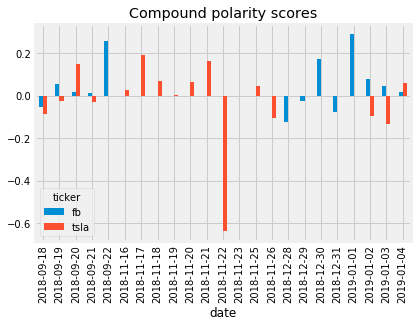

In [27]:
# Plot a bar chart with pandas
mean_c.plot.bar(title='Compound polarity scores')

## 7. Weekends and duplicates
<p>What happened to Tesla on November 22nd? Since we happen to have the headlines inside our <code>DataFrame</code>, a quick peek reveals that there are a few problems with that particular day: </p>
<ul>
<li>There are only 5 headlines for that day.</li>
<li>Two headlines are verbatim the same as another but from another news outlet.</li>
</ul>
<p>Let's clean up the dataset a bit, but not too much! While some headlines are the same news piece from different sources, the fact that they are written differently could provide different perspectives on the same story. Plus, when one piece of news is more important, it tends to get more headlines from multiple sources. What we want to get rid of is verbatim copied headlines, as these are very likely coming from the same journalist and are just being "forwarded" around, so to speak.</p>

In [28]:
# Note, If headline includes time, there are no duplicates. In this case, fix part 3.
# Count the number of headlines in scored_news (store as integer)
num_news_before = scored_news['headline'].count()
# Drop duplicates based on ticker and headline
scored_news_clean = scored_news.drop_duplicates(subset=['ticker', 'headline'])
# Count number of headlines after dropping duplicates
num_news_after = scored_news_clean['headline'].count()
# Print before and after numbers to get an idea of how we did 
f"Before we had {num_news_before} headlines, now we have {num_news_after}"

'Before we had 500 headlines, now we have 476'

## 8. Sentiment on one single trading day and stock
<p>Just to understand the possibilities of this dataset and get a better feel of the data, let's focus on one trading day and one single stock. We will make an informative plot where we will see the smallest grain possible: headline and subscores.</p>

In [29]:
# Set the index to ticker and date
single_day = scored_news_clean.set_index(['ticker', 'date'])
single_day.head(3)

time                                           headline  \
ticker date                                                                     
tsla   2018-11-26  01:25PM  Tesla was weeks from dying earlier this year, ...   
       2018-11-26  01:08PM  Elon Musk Says Tesla Was 'Close to Death' Duri...   
       2018-11-26  01:07PM  Tesla Almost Died Earlier This Year, Says Elon...   

                     neg    neu  pos  compound  
ticker date                                     
tsla   2018-11-26  0.000  1.000  0.0    0.0000  
       2018-11-26  0.281  0.719  0.0   -0.5994  
       2018-11-26  0.292  0.708  0.0   -0.5118

In [30]:
# Cross-section the fb row
single_day = single_day.xs('fb')
single_day.head(3)

,time,headline,neg,neu,pos,compound
date,,,,,,
2019-01-04,06:22PM,"Facebook, Apple, Netflix, Amazon and Alphabet ...",0.0,0.631,0.369,0.4767
2019-01-04,05:15PM,Earnings Reports for the Week of Jan. 7-11 (BB...,0.0,1.000,0.000,0.0000
2019-01-04,04:55PM,COLUMN-Commentary: 2019 will be the year of mo...,0.0,1.000,0.000,0.0000


In [31]:
# Select the 3rd of January of 2019
single_day = single_day['January 3rd, 2019']
single_day.head()

,time,headline,neg,neu,pos,compound
date,,,,,,
2019-01-03,10:59PM,[$$] Facebook Begins New Year in Fixer-Upper Mode,0.0,1.000,0.000,0.0000
2019-01-03,05:45PM,Investors Are Focused Too Closely on Facebook ...,0.0,0.652,0.348,0.5859
2019-01-03,05:24PM,Facebook (FB) Reportedly Testing Dark Mode on ...,0.0,1.000,0.000,0.0000
2019-01-03,04:10PM,"Google Stock Upgraded, Viewed As 'Most Defensi...",0.0,0.878,0.122,0.1010
2019-01-03,03:26PM,Is Facebook Stock the Best FANG Stock to Buy?,0.0,0.656,0.344,0.6369


In [32]:
# Convert the datetime string to just the time
single_day['time'] = pd.to_datetime(single_day['time']).dt.time
# Set the index to time and 
single_day = single_day.set_index('time')
# Sort it
single_day = single_day.sort_index()
single_day.head()

,headline,neg,neu,pos,compound
time,,,,,
06:00:00,Why Internet Censorship Doesnt Work and Never ...,0.000,1.000,0.000,0.0000
08:04:00,"3 Big Stock Charts for Thursday: Medtronic, Fa...",0.000,1.000,0.000,0.0000
09:07:00,"The Zacks Analyst Blog Highlights: Facebook, W...",0.000,0.846,0.154,0.2500
09:12:00,Why The FAANGs Are Crucial To A 2019 Market Rally,0.000,1.000,0.000,0.0000
09:34:00,Apple warning stoking fears of slowdown in Chi...,0.426,0.574,0.000,-0.6369


## 9. Visualize the single day
<p>We will make a plot to visualize the positive, negative and neutral scores for a single day of trading and a single stock. This is just one of the many ways to visualize this dataset.</p>

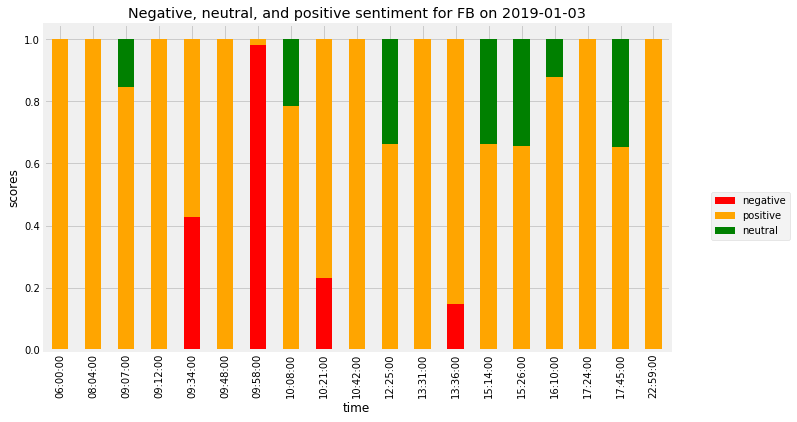

In [33]:
TITLE = "Negative, neutral, and positive sentiment for FB on 2019-01-03"
COLORS = ["red","orange", "green"]
# Drop the columns that aren't useful for the plot
plot_day = single_day.drop(columns=['compound', 'headline'])
# Change the column names to 'negative', 'positive', and 'neutral'
plot_day.columns = ['negative', 'positive', 'neutral']
# Plot a stacked bar chart
plot_day.plot.bar(stacked = True, 
                  figsize=(10, 6), 
                  title = TITLE, 
                  color = COLORS).legend(bbox_to_anchor=(1.2, 0.5))
plt.ylabel("scores");